In [2]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

from codeattention.source_code import SourceCode

from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon

from attwizard.script.utils import read_data_in_parallel
from attwizard.script.utils import load_json_file

# EDA
from attwizard.visualizer.eda import visualize_corr_vs
from attwizard.visualizer.eda import visualize_code_heatmap_codegen
from attwizard.visualizer.eda import plot_histogram_in_parallel

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
HUMAN_EXPERIMENT = "eye_v10"  # batch 1 and batch 2 and batch 3 and batch 4
MACHINE_EXPERIMENT = "exp_v10"  # CodeGen (3 tries)
COMPARISON_FOLDER = "cmp_v05"
OUT_PAPER_FOLDER = "../data/paper_figures"

# CodeGen

In [5]:
# LOAD COMPARISON DATA
PATH_COMPARISON_FOLDER = f'../data/comparisons/{COMPARISON_FOLDER}/'
available_comparisons = os.listdir(PATH_COMPARISON_FOLDER)
dfs = []
for comparison in available_comparisons:
    df = pd.read_csv(os.path.join(PATH_COMPARISON_FOLDER, comparison))
    dfs.append(df)
DF = pd.concat(dfs)
DF["comparison_name"].unique()

array(['tl_top3_uniform', 'tt_spearman_uniform', 'tt_top10_uniform',
       'tl_mse_uniform', 'tl_rank_humans', 'tl_spearman_followup',
       'tt_top10_followup', 'tt_spearman_copycat', 'tl_spearman_naivemax',
       'tl_rank_followup', 'tl_rank_uniform', 'plain_weights_humans',
       'tt_rank_uniform', 'tl_rank_copycat', 'tl_mse_humans',
       'tl_top3_humans', 'tt_spearman_humans', 'tl_spearman_uniform',
       'tt_mse_humans', 'tl_mse_followup', 'tt_rank_naivemax',
       'tl_top3_followup', 'tl_spearman_copycat', 'tl_mse_naivemax',
       'tt_rank_followup', 'tt_top10_naivemax', 'tl_top3_copycat',
       'tt_mse_followup', 'tt_mse_copycat', 'tl_top3_naivemax',
       'tt_spearman_naivemax', 'tl_spearman_humans', 'tt_rank_humans',
       'tl_rank_naivemax', 'tt_rank_copycat',
       'plain_weights_meanfollowers', 'tt_mse_uniform',
       'tt_spearman_followup', 'tt_top10_humans', 'tt_mse_naivemax',
       'tt_top10_copycat', 'tl_mse_copycat'], dtype=object)

In [27]:

# define the vector datasets
df_human_vs_model_codegen_same_question_res = DF[
    (DF["comparison_name"].isin(["plain_weights_meanfollowers"]))]
df_human_vs_humans_eye_tracking = DF[
    (DF["comparison_name"].isin(["plain_weights_humans"]))]

vector_comparisons = [
    {
        "short": "human_vs_model_codegen_same_question",
        "long": "Human vs Model - Same question",
        'data': df_human_vs_model_codegen_same_question_res[
            df_human_vs_model_codegen_same_question_res["pvalue"] < 0.05],
        'color': 'lightblue'
    },
    {
        "short": "human_vs_human_same_question",
        "long": "Human vs Human - Same question",
        "data": df_human_vs_humans_eye_tracking[
            df_human_vs_humans_eye_tracking["pvalue"] < 0.05],
        'color': 'lime'
    },
]

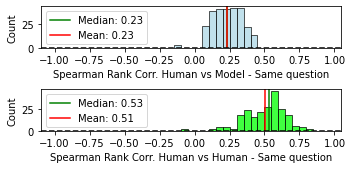

In [28]:
plot_histogram_in_parallel(
    vector_comparisons,
    col_name="correlation",
    common_prefix="Spearman Rank Corr.",
    bins=np.arange(-1, 1, 0.05),
    vertical_zero_line=True, 
    out_path=os.path.join(OUT_PAPER_FOLDER, "vector_agreement_simple.pdf"),
)

# MSE

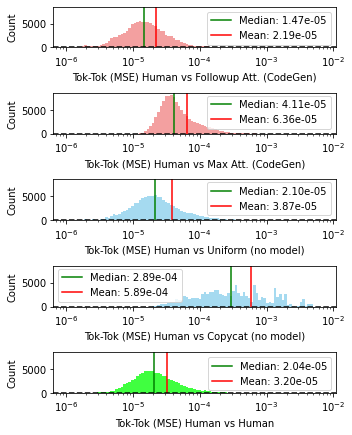

In [29]:
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_mse_followup") & 
            (DF["mse.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_mse_naivemax") &
            (DF["mse.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_mse_uniform") &
            (DF["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_mse_copycat") &
            (DF["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tt_mse_humans") &
            (DF["mse.value"] != -1)],
        'color': 'lime',
    }
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="mse.value",
    common_prefix="Tok-Tok (MSE)",
    #bins=np.arange(0, 0.0002, 0.00001),
    bins=np.logspace(np.log10(10e-7), np.log10(0.007), 100),
    scale="log",
    fmt=".2e",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_mse_histogram_simple.pdf"),
)

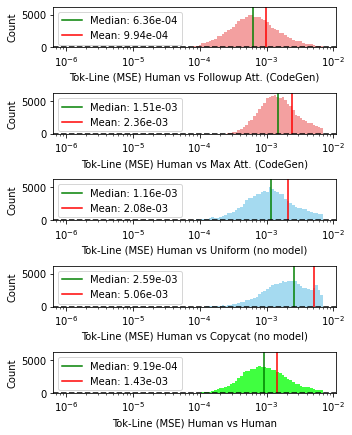

In [33]:
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_mse_followup") & 
            (DF["mse.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_mse_naivemax") &
            (DF["mse.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_mse_uniform") &
            (DF["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_mse_copycat") &
            (DF["mse.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tl_mse_humans") &
            (DF["mse.value"] != -1)],
        'color': 'lime',
    }
]


plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="mse.value",
    common_prefix="Tok-Line (MSE)",
    #bins=np.arange(0, 0.0002, 0.00001),
    bins=np.logspace(np.log10(10e-7), np.log10(0.007), 100),
    scale="log",
    fmt=".2e",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_mse_histogram_simple.pdf"),
)

# RANK 

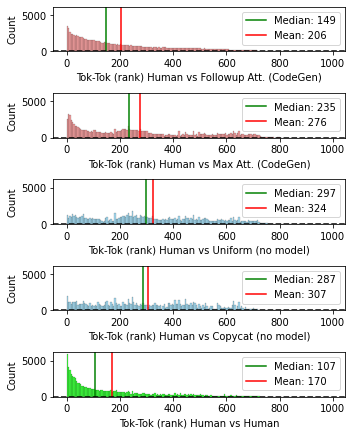

In [31]:
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_rank_followup") & 
            (DF["rank.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_rank_naivemax") &
            (DF["rank.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_rank_uniform") &
            (DF["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_rank_copycat") &
            (DF["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tt_rank_humans") &
            (DF["rank.value"] != -1)],
        'color': 'lime',
    }
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="rank.value",
    common_prefix="Tok-Tok (rank)",    
    bins=np.arange(0, 1000, 5),
    fmt=".0f",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_rank_histogram_simple.pdf"),
)

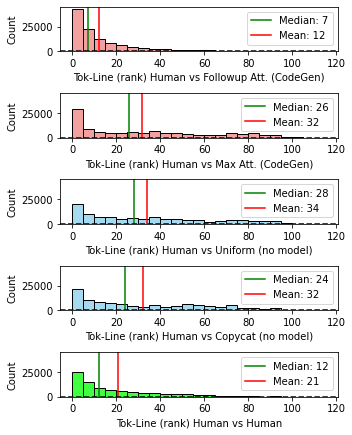

In [37]:

matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_rank_followup") & 
            (DF["rank.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_rank_naivemax") &
            (DF["rank.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_rank_uniform") &
            (DF["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_rank_copycat") &
            (DF["rank.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tl_rank_humans") &
            (DF["rank.value"] != -1)],
        'color': 'lime',
    }
]


plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="rank.value",
    common_prefix="Tok-Line (rank)",    
    bins=np.arange(0, 120, 5),
    fmt=".0f",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_rank_histogram_simple.pdf"),
)

# Spearman

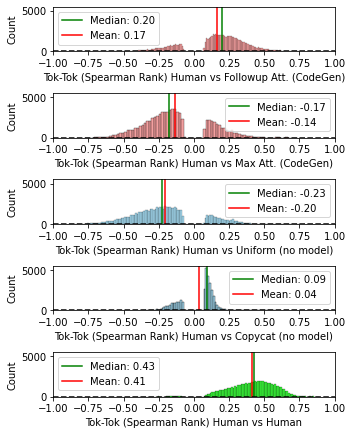

In [11]:
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_spearman_followup") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_spearman_naivemax") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_spearman_uniform") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_spearman_copycat") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tt_spearman_humans") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'lime',
    }
]
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Tok-Tok (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_spearman_histogram.pdf"),
)

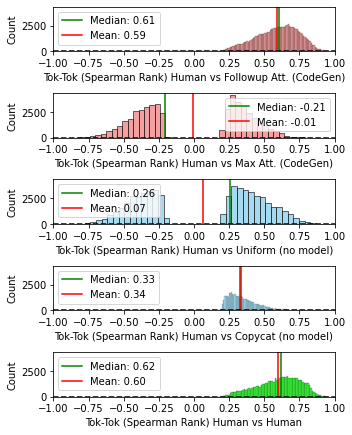

In [12]:

matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_followup") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_naivemax") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_spearman_uniform") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_spearman_copycat") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tl_spearman_humans") &
            (DF["spearman_res.pval"] <= 0.05) &
            (DF["spearman_res.corr"] != -1)],
        'color': 'lime',
    }
]
plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="spearman_res.corr",
    common_prefix="Tok-Tok (Spearman Rank)",
    sharey=True, 
    xlim=(-1, 1),
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_spearman_histogram.pdf"),
)

# Top-10 Token

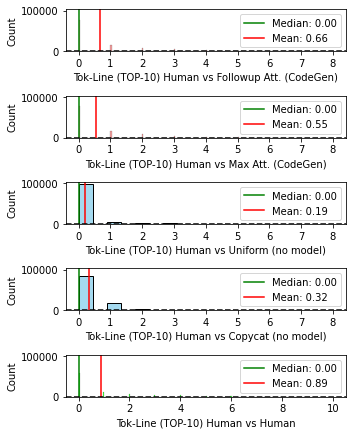

In [14]:
matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_top10_followup") & 
            (DF["top_10.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tt_top10_naivemax") &
            (DF["top_10.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_top10_uniform") &
            (DF["top_10.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tt_top10_copycat") &
            (DF["top_10.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tt_top10_humans") &
            (DF["top_10.value"] != -1)],
        'color': 'lime',
    }
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="top_10.value",
    common_prefix="Tok-Line (TOP-10)",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tt_top10_histogram.pdf"),
)

# Top-3

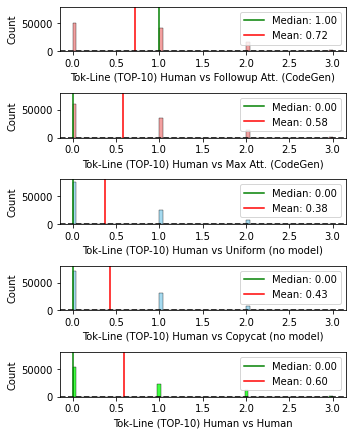

In [15]:

matrix_comparisons = [   
    {
        "short": "human_vs_followup",
        "long": "Human vs Followup Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_top3_followup") & 
            (DF["top_3.value"] != -1)],
        'color': 'lightcoral',
    },
    {
        "short": "human_vs_max",
        "long": "Human vs Max Att. (CodeGen)",
        'data': DF[
            (DF["comparison_name"] == "tl_top3_naivemax") &
            (DF["top_3.value"] != -1)],
        "color": 'lightcoral',
    },
    {
        "short": "human_vs_uniform",
        "long": "Human vs Uniform (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_top3_uniform") &
            (DF["top_3.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": "human_vs_copycat",
        "long": "Human vs Copycat (no model)",
        "data": DF[
            (DF["comparison_name"] == "tl_top3_copycat") &
            (DF["top_3.value"] != -1)],
        'color': 'skyblue',
    },
    {
        "short": 'human_vs_human',
        'long': 'Human vs Human',
        'data': DF[
            (DF["comparison_name"] == "tl_top3_humans") &
            (DF["top_3.value"] != -1)],
        'color': 'lime',
    }
]

plot_histogram_in_parallel(
    matrix_comparisons,
    col_name="top_3.value",
    common_prefix="Tok-Line (TOP-10)",
    sharey=True, 
    vertical_zero_line=True, 
    data_attribute="data",
    out_path=os.path.join(OUT_PAPER_FOLDER, "tl_top3_histogram.pdf"),
)